In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ImageSize = 224
BatchSize = 32
Channels = 3
Epochs = 50
n_classes = 4

In [3]:
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    'image',
    shuffle=True,
    image_size=(ImageSize,ImageSize),
    batch_size=BatchSize
)

Found 6161 files belonging to 4 classes.


In [4]:
class_names = data_set.class_names

In [5]:
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy']

In [6]:
len(data_set)

193

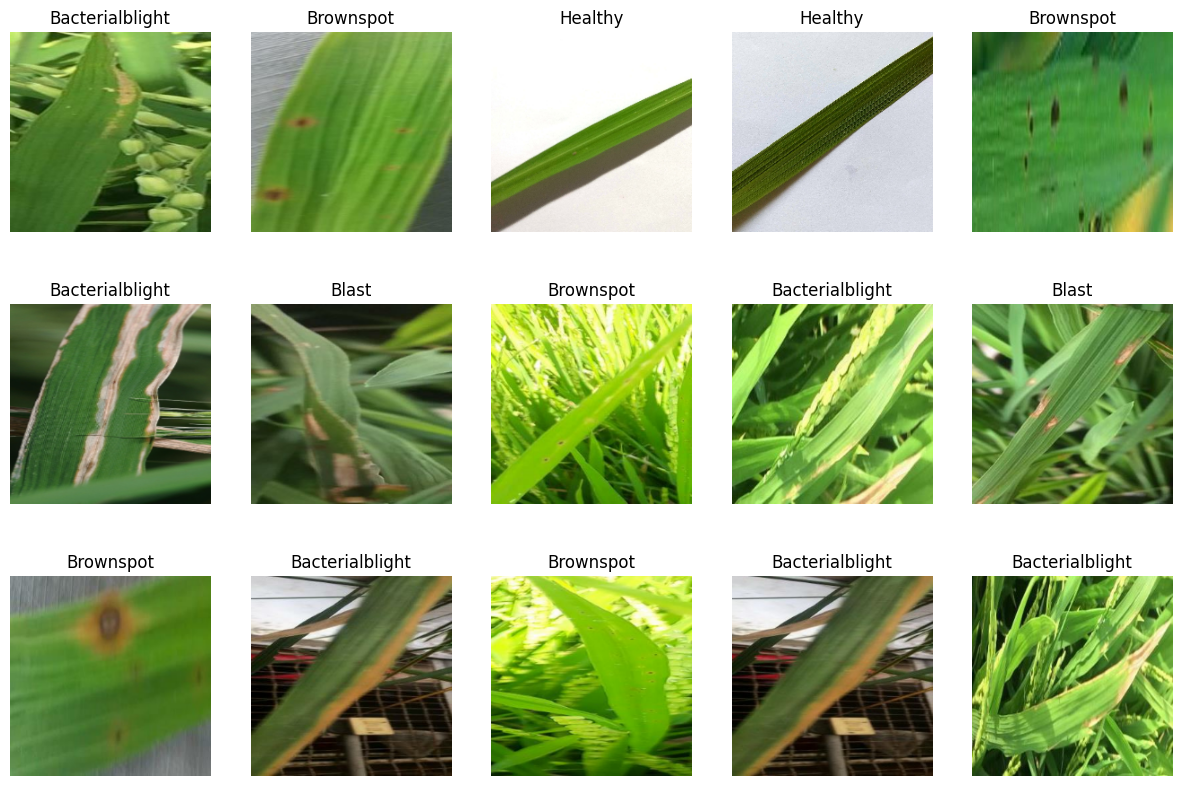

In [7]:
plt.figure(figsize=(15,10))
for images_batch, label_batch in data_set.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])    
    

In [8]:
for images_batch, label_batch in data_set.take(1):
    print(images_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[3 3 1 3 0 0 3 2 3 2 1 2 0 1 2 2 1 0 1 3 3 2 0 0 0 1 1 3 2 1 2 1]


In [9]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_slpit=0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = split_dataset(data_set)

In [11]:
len(train_ds)

154

In [12]:
len(test_ds)

20

In [13]:
len(val_ds)

19

## Build model

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(ImageSize,ImageSize),
    layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [19]:
from keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet',include_top=False, input_shape=(ImageSize, ImageSize, Channels))

In [20]:
for layer in base_model.layers:  
    layer.trainable = False  

In [23]:
input_shape = (ImageSize, ImageSize, Channels)

model = models.Sequential([
    resize_and_rescale, 
    data_augmentation,
    base_model,

    # Fully Connected Layers
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation="softmax")  
])

model.build(input_shape=(BatchSize, ImageSize, ImageSize, Channels))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (32, 7, 7, 1280)            │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (32, 1280)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 1280)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 128)                   │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 4)                     │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs = Epochs,
    batch_size = BatchSize,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 75s 420ms/step - accuracy: 0.7151 - loss: 0.7366 - val_accuracy: 0.9276 - val_loss: 0.1958
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 61s 399ms/step - accuracy: 0.9206 - loss: 0.2240 - val_accuracy: 0.9523 - val_loss: 0.1367
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 61s 397ms/step - accuracy: 0.9453 - loss: 0.1534 - val_accuracy: 0.9638 - val_loss: 0.0974
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 391ms/step - accuracy: 0.9623 - loss: 0.1088 - val_accuracy: 0.9688 - val_loss: 0.0863
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 63s 409ms/step - accuracy: 0.9666 - loss: 0.0905 - val_accuracy: 0.9737 - val_loss: 0.0661
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 61s 399ms/step - accuracy: 0.9777 - loss: 0.0705 - val_accuracy: 0.9852 - val_loss: 0.0567
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 392ms/step - accuracy: 0.9785 - loss: 0.0677 - val_accuracy: 0.9885 - val_loss: 0.0380
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 61s 395ms/step - accuracy: 0.9787 - loss: 0

In [27]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.9994 - loss: 0.0054


In [28]:
scores

[0.005464893765747547, 0.9984375238418579]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 154}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

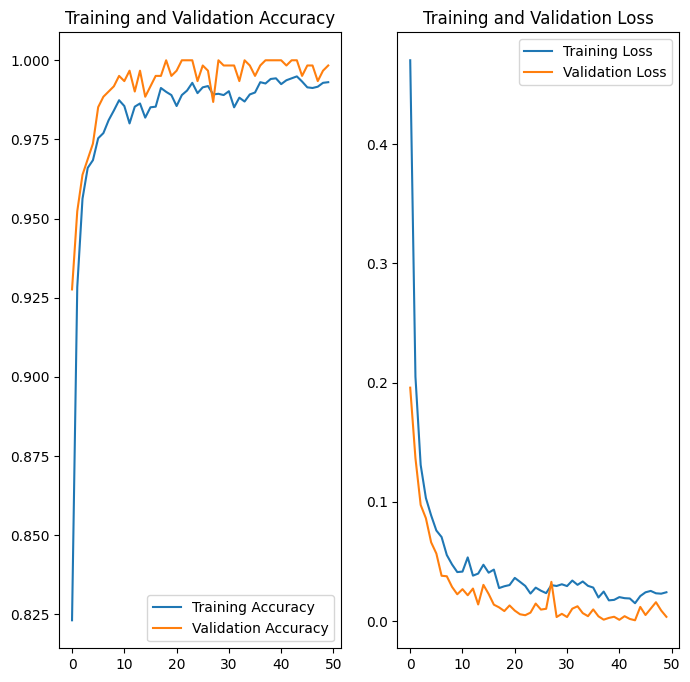

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
def Predict(model, img):
    img = tf.expand_dims(img,0)
    predictions = model.predict(img)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


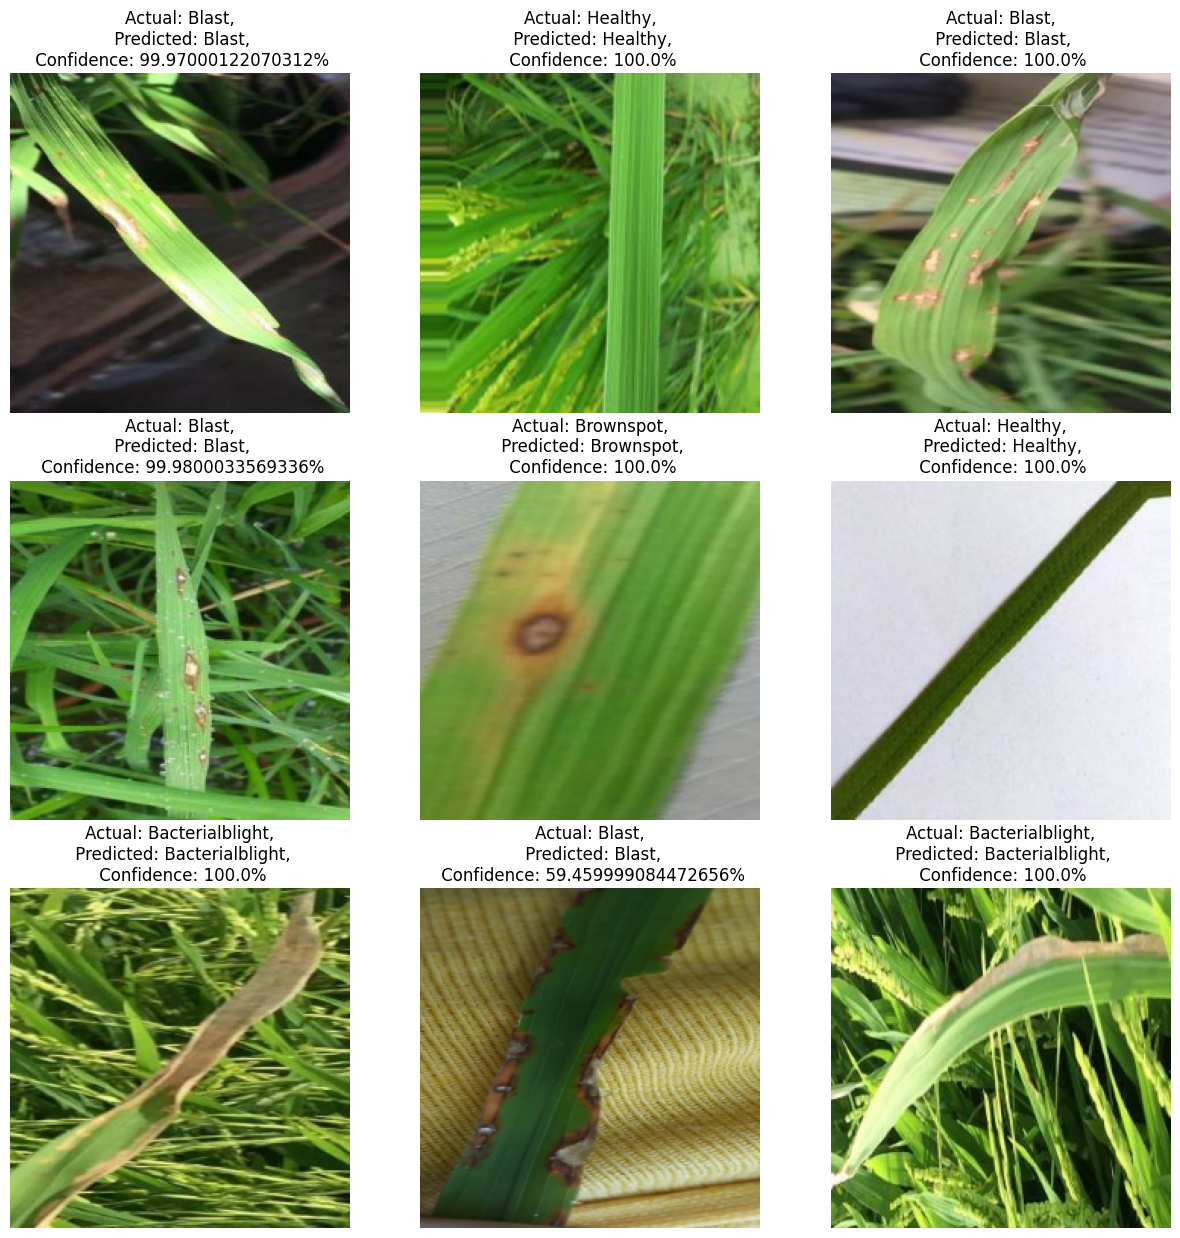

In [38]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = Predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")
    

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Dự đoán trên tập test
y_pred = model.predict(test_ds)

# Chuyển đổi y_pred thành các nhãn lớp 
y_pred_classes = np.argmax(y_pred, axis=1)

y_test = []
for img_batch, label_batch in test_ds:
    y_test.extend(label_batch.numpy()) 

# In ra báo cáo phân loại và ma trận nhầm lẫn
print("Classification Report: \n", classification_report(y_test, y_pred_classes))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_classes))


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       176
           1       0.99      1.00      1.00       150
           2       1.00      1.00      1.00       147
           3       1.00      1.00      1.00       167

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640

Confusion Matrix: 
 [[175   1   0   0]
 [  0 150   0   0]
 [  0   0 147   0]
 [  0   0   0 167]]


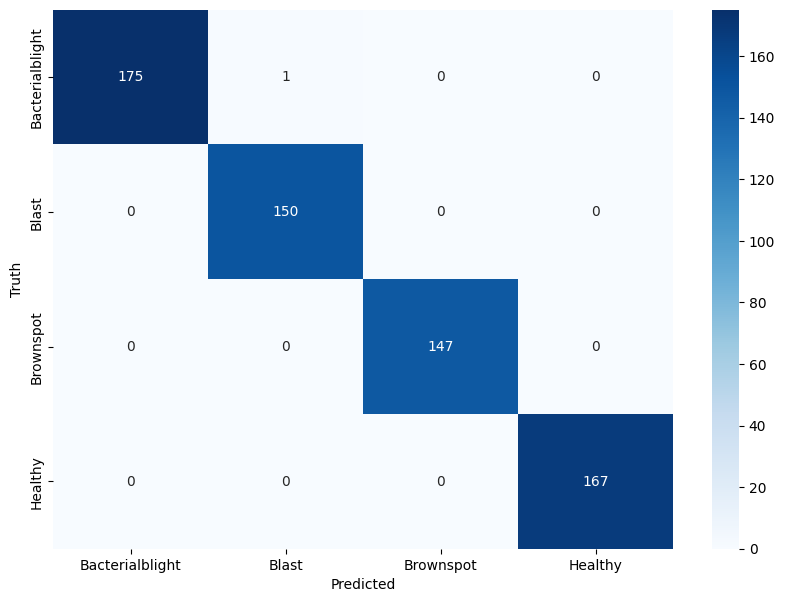

In [40]:
import seaborn as sns
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues', xticklabels=['Bacterialblight', 'Blast', 'Brownspot', 'Healthy'],
                    yticklabels=['Bacterialblight', 'Blast', 'Brownspot', 'Healthy'])
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [70]:
import os
import re

# Lấy danh sách các file trong thư mục models
model_files = os.listdir("./models")

# Lọc ra các file có định dạng số ở đầu và kết thúc bằng .keras
model_versions = [
    int(re.match(r"(\d+)\.keras", file).group(1))
    for file in model_files
    if re.match(r"(\d+)\.keras", file)
]

# Tìm phiên bản lớn nhất và tăng lên 1
model_version = max(model_versions + [0]) + 1

# Lưu model với phiên bản mới
model.save(f"./models/{model_version}.keras")


In [15]:
MODEL = tf.keras.models.load_model("./models/29.keras")

In [21]:
def Predict(model, img):
    img_array = img
    img_array = tf.expand_dims(img_array, 0)  # create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


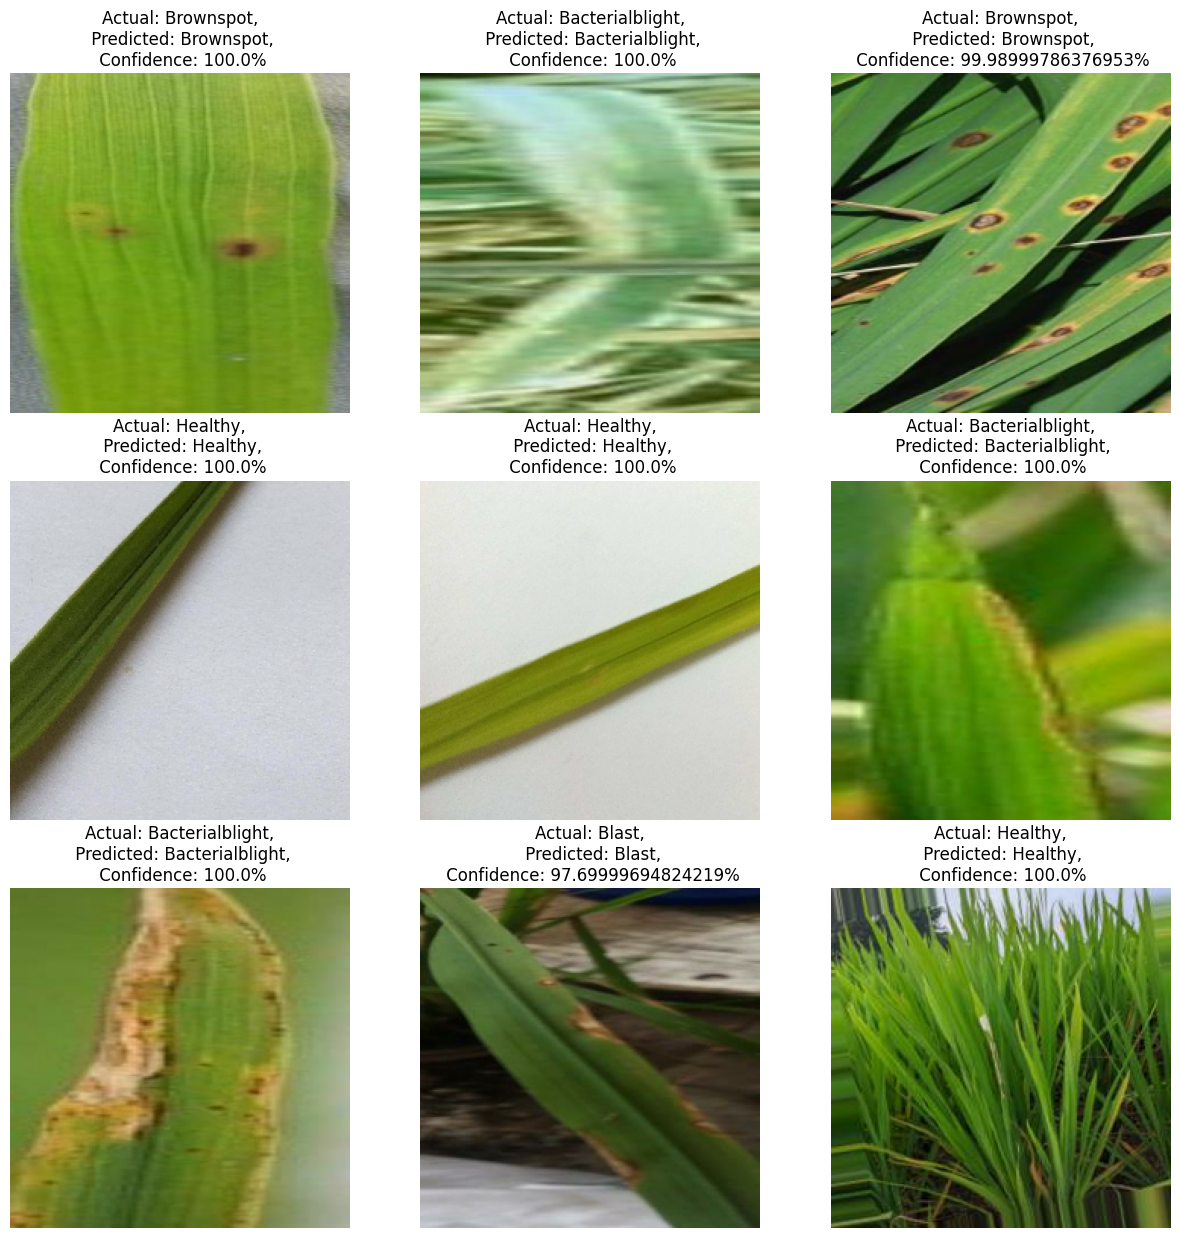

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = Predict(MODEL,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")
    

Image to predict
Actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
Predict label: [6.221901e-07 3.172826e-04 9.996822e-01]


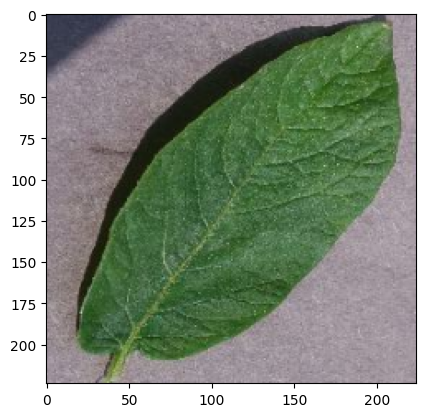

In [19]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("Image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    batch_prediction = MODEL.predict(images_batch)
    print("Predict label:",batch_prediction[0])